# Tutorial 3: Running Quantization-Aware Training (QAT) on Bert

In this tutorial, we'll build on top of Tutorial 2 by taking the Bert model fine tuned for sequence classification and running Mase's quantization pass. First, we'll run simple Post-Training Quantization (PTQ) and see how much accuracy drops. Then, we'll run some further training iterations of the quantized model (i.e. QAT) and see whether the accuracy of the trained quantized model approaches the accuracy of the original (full-precision) model.

In [ ]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can create a MaseGraph for Bert by running the following cell.

In [ ]:
from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.config.problem_type = "single_label_classification"

mg = MaseGraph(
    model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

If you have previously ran the tutorial on LoRA Finetuning, run the following cell to import the fine tuned checkpoint.

In [ ]:
from pathlib import Path
from chop import MaseGraph

mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_2_lora")

WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.


## Post-Training Quantization (PTQ)

Here, we simply quantize the model and evaluate the effect in its accuracy. First, let's evaluate the model accuracy before quantization (if you're coming from Tutorial 2, this should be the same as the post-LoRA evaluation accuracy). As seen in Tutorial 2, we can use the `get_tokenized_dataset` and `get_trainer` utilities to generate a HuggingFace `Trainer` instance for training and evaluation.

In [14]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
Map:  76%|███████▌  | 19000/25000 [00:05<00:01, 5030.52 examples/s]Exception ignored in: <function Dataset.__del__ at 0x1675e27a0>
Traceback (most recent call last):
  File "/Users/souparna/mase/.venv/lib/python3.11/site-packages/datasets/arrow_dataset.py", line 1418, in __del__
    if hasattr(self, "_indices"):
       ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 
Map: 100%|██████████| 25000/25000 [00:07<00:00, 3281.65 examples/s]
/Users/souparna/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


KeyboardInterrupt: 

To run the quantization pass, we pass a quantization configuration dictionary as argument. This defines the quantization mode, numerical format and precision for each operator in the graph. We'll run the quantization in "by type" mode, meaning nodes are quantized according to their `mase_op`. Other modes include by name and by regex name. We'll quantize all activations, weights and biases in the model to fixed-point with the same precision. This may be sub-optimal, but works as an example. In future tutorials, we'll see how to run the `search` flow in `Mase` to find optimal quantization configurations to minimize accuracy loss.

In [ ]:
import chop.passes as passes

quantization_config = {
    "by": "type", # Sets to select the layers to quatisation via the type of the layers, e.g. linear or conv
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}

mg, _ = passes.quantize_transform_pass(
    mg,
    pass_args=quantization_config,
)

Let's evaluate the immediate effect of quantization on the model accuracy.

In [ ]:
trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

/Users/souparna/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.77644


We can save the current checkpoint for future reference (optional).

In [ ]:
from pathlib import Path

mg.export(f"{Path.home()}/tutorial_3_ptq")

INFO     Exporting MaseGraph to /Users/souparna/tutorial_3_ptq.pt, /Users/souparna/tutorial_3_ptq.mz
INFO     Exporting GraphModule to /Users/souparna/tutorial_3_ptq.pt
INFO     Saving full model format


INFO     Exporting MaseMetadata to /Users/souparna/tutorial_3_ptq.mz


## Quantization-Aware Training (QAT)

You should have seen in the last section that quantization can lead to a significant drop in accuracy. Next, we'll run QAT to evaluate whether this performance gap can be reduced. To run QAT in Mase, all you need to do is include the model back in your training loop after running the quantization pass.

In [ ]:
# Evaluate accuracy
trainer.train()
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

 16%|█▌        | 501/3125 [00:36<02:57, 14.80it/s]

{'loss': 0.4017, 'grad_norm': 10.568283081054688, 'learning_rate': 4.2e-05, 'epoch': 0.16}


 32%|███▏      | 1000/3125 [00:59<01:57, 18.05it/s]

{'loss': 0.3918, 'grad_norm': 7.2999749183654785, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.32}


 48%|████▊     | 1501/3125 [01:21<00:53, 30.53it/s]

{'loss': 0.3987, 'grad_norm': 11.782495498657227, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.48}


 64%|██████▍   | 2000/3125 [01:41<01:07, 16.55it/s]

{'loss': 0.3906, 'grad_norm': 6.373114585876465, 'learning_rate': 1.8e-05, 'epoch': 0.64}


 80%|████████  | 2504/3125 [01:59<00:20, 30.69it/s]

{'loss': 0.382, 'grad_norm': 8.522379875183105, 'learning_rate': 1e-05, 'epoch': 0.8}


 96%|█████████▌| 3000/3125 [02:15<00:04, 25.00it/s]

{'loss': 0.3914, 'grad_norm': 10.293235778808594, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.96}


100%|██████████| 3125/3125 [02:20<00:00, 22.26it/s]


{'train_runtime': 140.3713, 'train_samples_per_second': 178.099, 'train_steps_per_second': 22.262, 'train_loss': 0.3934635339355469, 'epoch': 1.0}


100%|██████████| 3125/3125 [00:51<00:00, 60.90it/s]

Evaluation accuracy: 0.84232


We can see the accuracy of the quantized model can match (or sometimes exceed) the full precision model, with a much lower memory requirement to store the weights. Finally, save the final checkpoint for future tutorials.

In [ ]:
from pathlib import Path

mg.export(f"{Path.home()}/tutorial_3_qat")

INFO     Exporting MaseGraph to /Users/souparna/tutorial_3_qat.pt, /Users/souparna/tutorial_3_qat.mz
INFO     Exporting GraphModule to /Users/souparna/tutorial_3_qat.pt
INFO     Saving full model format
INFO     Exporting MaseMetadata to /Users/souparna/tutorial_3_qat.mz


### Task 1

Load Base Model

In [16]:
from pathlib import Path
from chop import MaseGraph

mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_2_lora")

from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
Map: 100%|██████████| 50000/50000 [00:12<00:00, 4112.61 examples/s]


Try different quantisation levels 

In [17]:
import matplotlib as plt 

ptq_list = []
qat_list = []


for ql in range (4,33,4): 

    # Quantise
    
    quantization_config = {
        "by": "type", # Sets to select the layers to quatisation via the type of the layers, e.g. linear or conv
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # data
                "data_in_width": ql,
                "data_in_frac_width": ql / 2 ,
                # weight
                "weight_width": ql,
                "weight_frac_width": ql / 2,
                # bias
                "bias_width": ql,
                "bias_frac_width": ql / 2,
            }
        },
    }

    q_mg, _ = passes.quantize_transform_pass(
        mg,
        pass_args=quantization_config,
    )
    trainer = get_trainer(
        model=q_mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
    )
    
    # PTQ
    
    eval_results = trainer.evaluate()
    print(f" PTQ Evaluation accuracy: {eval_results['eval_accuracy']} with quantisation {ql}")
    ptq_list.append(eval_results['eval_accuracy'])
    
    # QAT 
    
    trainer.train()
    eval_results = trainer.evaluate()
    print(f" QAT Evaluation accuracy: {eval_results['eval_accuracy']} with quantisation {ql}")
    
    qat_list.append(eval_results['eval_accuracy'])


/Users/souparna/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


 PTQ Evaluation accuracy: 0.5 with quantisation 4


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


 QAT Evaluation accuracy: 0.5 with quantisation 4


/Users/souparna/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


 PTQ Evaluation accuracy: 0.79808 with quantisation 8


Step,Training Loss
500,0.409600
1000,0.391700
1500,0.398300
2000,0.387400
2500,0.393100
3000,0.389100


 QAT Evaluation accuracy: 0.83936 with quantisation 8


/Users/souparna/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


 PTQ Evaluation accuracy: 0.83492 with quantisation 12


Step,Training Loss
500,0.402000
1000,0.382800
1500,0.395300
2000,0.379300
2500,0.386200
3000,0.387000


 QAT Evaluation accuracy: 0.8416 with quantisation 12


/Users/souparna/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


 PTQ Evaluation accuracy: 0.83472 with quantisation 16


Step,Training Loss
500,0.398300
1000,0.381100
1500,0.392100
2000,0.376000
2500,0.386100
3000,0.384400


 QAT Evaluation accuracy: 0.84192 with quantisation 16


/Users/souparna/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


 PTQ Evaluation accuracy: 0.8358 with quantisation 20


Step,Training Loss
500,0.399100
1000,0.380800
1500,0.393200
2000,0.376500
2500,0.386000
3000,0.384100


 QAT Evaluation accuracy: 0.84192 with quantisation 20


/Users/souparna/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


 PTQ Evaluation accuracy: 0.83556 with quantisation 24


Step,Training Loss
500,0.398800
1000,0.380900
1500,0.393100
2000,0.376400
2500,0.386000
3000,0.384100


 QAT Evaluation accuracy: 0.84192 with quantisation 24


/Users/souparna/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


 PTQ Evaluation accuracy: 0.83556 with quantisation 28


Step,Training Loss
500,0.398700
1000,0.380800
1500,0.393000
2000,0.376300
2500,0.386000
3000,0.384200


 QAT Evaluation accuracy: 0.84176 with quantisation 28


/Users/souparna/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


 PTQ Evaluation accuracy: 0.83564 with quantisation 32


Step,Training Loss
500,0.398700
1000,0.380700
1500,0.393000
2000,0.376300
2500,0.386000
3000,0.384200


 QAT Evaluation accuracy: 0.84192 with quantisation 32


In [18]:
print(ptq_list)

[0.5, 0.79808, 0.83492, 0.83472, 0.8358, 0.83556, 0.83556, 0.83564]


In [19]:
print(qat_list)

[0.5, 0.83936, 0.8416, 0.84192, 0.84192, 0.84192, 0.84176, 0.84192]


##### Plotting Data 

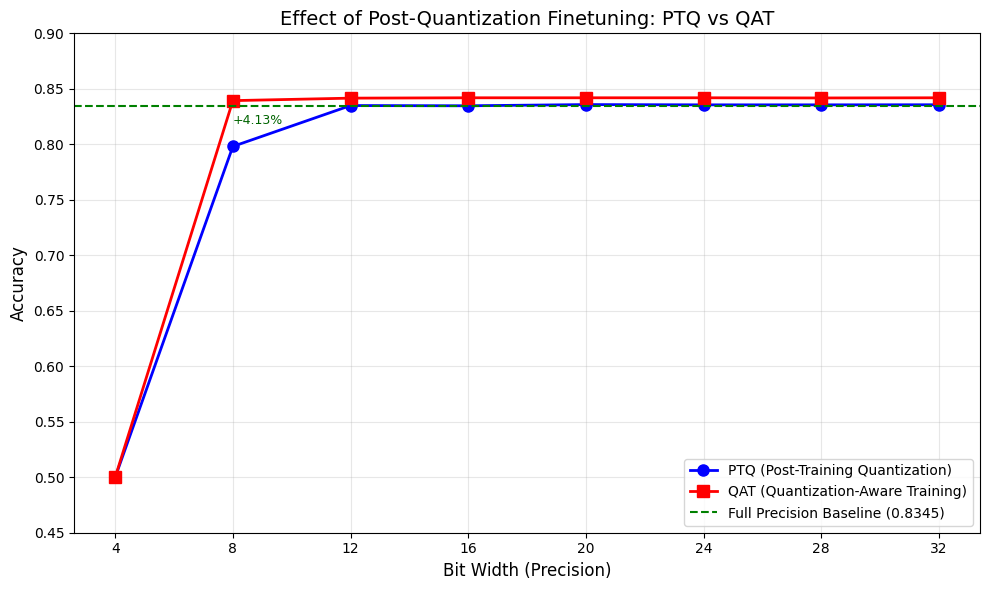

In [20]:
import matplotlib.pyplot as plt

bit_widths = list(range(4, 33, 4))  # [4, 8, 12, 16, 20, 24, 28, 32]

plt.figure(figsize=(10, 6))

# Plot PTQ and QAT curves
plt.plot(bit_widths, ptq_list, 'o-', label='PTQ (Post-Training Quantization)', 
         color='blue', linewidth=2, markersize=8)
plt.plot(bit_widths, qat_list, 's-', label='QAT (Quantization-Aware Training)', 
         color='red', linewidth=2, markersize=8)

# Add baseline (full precision) accuracy if available
baseline_accuracy = 0.83452  # From your earlier evaluation
plt.axhline(y=baseline_accuracy, color='green', linestyle='--', 
            label=f'Full Precision Baseline ({baseline_accuracy:.4f})', linewidth=1.5)

plt.xlabel('Bit Width (Precision)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Effect of Post-Quantization Finetuning: PTQ vs QAT', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(bit_widths)
plt.ylim(0.45, 0.90)

# Annotate the accuracy improvement at each precision
for i, bw in enumerate(bit_widths):
    if i < len(ptq_list) and i < len(qat_list):
        improvement = qat_list[i] - ptq_list[i]
        if improvement > 0.01:  # Only annotate significant improvements
            mid_y = (ptq_list[i] + qat_list[i]) / 2
            plt.annotate(f'+{improvement:.2%}', xy=(bw, mid_y), 
                        fontsize=9, ha='left', color='darkgreen')

plt.tight_layout()
plt.show()
